In [ ]:
!pip install python-dotenv
!pip install matplotlib
!pip install pillow

In [1]:
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dotenv import load_dotenv
from os import getenv
from IPython.display import HTML, Image
from PIL import Image


## Code to display a bunch of URLs in a gallery

In [2]:
load_dotenv()
api_key = getenv('API_KEY', '')
base_url = getenv('BASE_URL', '')

def _src_from_data(data):
    """Base64 encodes image bytes for inclusion in an HTML img element"""
    img_obj = Image(data=data)
    for bundle in img_obj._repr_mimebundle_():
        for mimetype, b64value in bundle.items():
            if mimetype.startswith('image/'):
                return f'data:{mimetype};base64,{b64value}'

def gallery(images, row_height='auto'):
    """Shows a set of images in a gallery that flexes with the width of the notebook.
    
    Parameters
    ----------
    images: list of str or bytes
        URLs or bytes of images to display

    row_height: str
        CSS height value to assign to all images. Set to 'auto' by default to show images
        with their native dimensions. Set to a value like '250px' to make all rows
        in the gallery equal height.
    """
    figures = []
    for image in images:
        if isinstance(image, bytes):
            src = _src_from_data(image)
            caption = ''
        else:
            src = image
            caption = f'<figcaption style="font-size: 0.6em">{image}</figcaption>'
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="{src}" style="height: {row_height}">
              {caption}
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

## Show a gallery of some snacks

In [3]:
urls = [
    'https://cdn-a.william-reed.com/var/wrbm_gb_food_pharma/storage/images/publications/food-beverage-nutrition/foodnavigator.com/article/2021/04/21/nestle-sets-carbon-target-for-kitkat-we-are-reducing-and-removing-emissions-to-reach-carbon-neutrality-by-2025/12383206-1-eng-GB/Nestle-sets-carbon-target-for-KitKat-We-are-reducing-and-removing-emissions-to-reach-carbon-neutrality-by-2025_wrbm_large.jpg',
    'https://media.glamour.com/photos/5f060cfd337cb0b5f29e5e40/master/w_2560%2Cc_limit/GettyImages-71805585.jpg'
]

gallery(urls, row_height='200px')

## Call Cognitive ML to guess the brand

In [4]:
image_url = urls[1]
body = { 'url': image_url }
headers = { 
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': api_key
}
response = requests.post(base_url, json=body, headers=headers)
res = json.loads(response.text)
# {'name': 'Kit Kat', 'confidence': 0.768, 'rectangle': {'x': 127, 'y': 101, 'w': 393, 'h': 238}}

guess = res['brands'][0]

# friendlier var names
brand = guess['name']
confidence = guess['confidence']
shape = 'rectangle'
x = guess[shape]['x']
y = guess[shape]['y']
w = guess[shape]['w']
h = guess[shape]['h']

print(f'Brand Guess: {brand} with a confidence of: {confidence}')
print(f'Dimensions: x: {x}, y: {y}, w: {w}, h: {h}')

Brand Guess: Dunkin' Donuts with a confidence of: 0.821
Dimensions: x: 366, y: 843, w: 882, h: 500


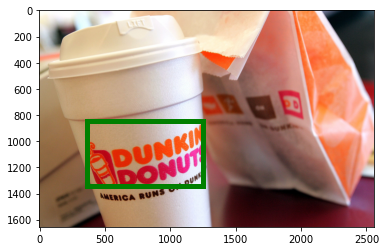

In [5]:
img = Image.open(requests.get(image_url, stream=True).raw)
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=5, edgecolor='g', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


## How Convolutional Neural Networks Work

### What you'll need
1. You need a lot of data. Images of the same thing in many orientations, lighting etc
2. You need the data to be labelled. E.g. what it is and the area of the interest (the bounding box)
3. A lot of computing power -- you'll see that people use graphics cards because they can crunch numbers much better than a general purpose CPU
4. Someone who knows how to not only do data science, but someone who knows how to deal with image data

### CNN Algorithm
1. Take the image and split it into smaller squares (convolution)
2. Try to keep the smaller squares that seem to *identify* or have a **significant** impact on the identification result
3. Flatten the wxh image into a big binary list of 0's and 1's as the *signature* of that brand
4. Guess the resulting brand, if it's incorrect, do it all over again until accuracy increases

Softmax function takes a vector of values and turns it all into a normalized value of 1. This can be interpreted as the **probability** that the image is brand XXX.
![convolution](https://cdn-images-1.medium.com/fit/t/1600/480/1*vkQ0hXDaQv57sALXAJquxA.jpeg)